#### Example

- two slices/scans of PET and correlated CT 

## Patient no 2
- dbfs:/mnt/phd/images/pacjenci/p2/2_1.CT.0002.0109.2017.12.15.12.58.59.687500.58582045.png
- dbfs:/mnt/phd/images/pacjenci/p2/2_1.PT.0102.0040.2017.12.15.12.58.59.687500.58566645.png

#### Preprocessing

In [3]:
import os
import re
import json


def get_corelated_file(path):
  core = path.split("_")
  patient_no = core[0]
  image_type = core[1]
  number = core[2]

  mypath = '/dbfs/mnt/phd/images/pacjenci/p' + patient_no + '/'

  dicom = '.IMA'
  png = '.png'
  jpg = '.jpg'

  if image_type.upper() == 'PET' or image_type.upper() == 'PT':
    image_type = 'PT'
    mapping = dict()
    for i in range(1, 149):
      value = 149 - i
      mapping[i] = value

    n = int(number)
    # it may be 1, til 149
    if len(str(mapping[n])) == 3:
      num = "0" + str(mapping[n])
    elif len(str(mapping[n])) == 2:
      num = "00" + str(mapping[n])
    else:
      num = "000" + str(mapping[n])

    assert len(num) is 4
    regex = '.*' + image_type + '(.*\.){2}' + num + '.*' + dicom
    res = [f for f in os.listdir(mypath) if re.match(rf'{regex}', f)]
    if len(res) == 0:
      print("[ERROR] Couldnt find any file. Regex return list = 0 ")
    r = mypath + res[0]

  else:
    regex = '.*' + image_type.upper() + '(.*\.){2}' + number + '.*' + dicom
    res = [f for f in os.listdir(mypath) if re.match(rf'{regex}', f)]
    r = mypath + res[0]


  return r

<>:39: DeprecationWarning: invalid escape sequence \.
<>:46: DeprecationWarning: invalid escape sequence \.
<>:39: DeprecationWarning: invalid escape sequence \.
<>:46: DeprecationWarning: invalid escape sequence \.
<command-4340721291427758>:39: DeprecationWarning: invalid escape sequence \.
 regex = '.*' + image_type + '(.*\.){2}' + num + '.*' + dicom
<command-4340721291427758>:46: DeprecationWarning: invalid escape sequence \.
 regex = '.*' + image_type.upper() + '(.*\.){2}' + number + '.*' + dicom

#### For automation purposes

In [5]:
dbutils.widgets.text("ct", "None")
dbutils.widgets.text("pet", "None")

ct = dbutils.widgets.get("ct")
pet = dbutils.widgets.get("pet")

#### Fusion strategy

In [7]:
import numpy as np
from imageio import imread

import torch
import torch.nn
from torchvision.models.vgg import vgg19_bn

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sporco.util import tikhonov_filter

import torch

def lowpass(s, lda, npad):
    return tikhonov_filter(s, lda, npad)

def c3(s):
    if s.ndim == 2:
        s3 = np.dstack([s, s, s])
    else:
        s3 = s
    return np.rollaxis(s3, 2, 0)[None, :, :, :]

def l1_features(out):
    h, w, d = out.shape
    A_temp = np.zeros((h+2, w+2))
    
    l1_norm = np.sum(np.abs(out), axis=2)
    A_temp[1:h+1, 1:w+1] = l1_norm
    return A_temp

def fusion_strategy(feat_a, feat_b, source_a, source_b, unit):
    
    m, n = feat_a.shape
    m1, n1 = source_a.shape[:2]
    weight_ave_temp1 = np.zeros((m1, n1))
    weight_ave_temp2 = np.zeros((m1, n1))
    
    for i in range(1, m):
        for j in range(1, n):
            A1 = feat_a[i-1:i+1, j-1:j+1].sum() / 9
            A2 = feat_b[i-1:i+1, j-1:j+1].sum() / 9
            
            weight_ave_temp1[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = A1 / (A1+A2)
            weight_ave_temp2[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = A2 / (A1+A2)

    if source_a.ndim == 3:
        weight_ave_temp1 = weight_ave_temp1[:, :, None]
    source_a_fuse = source_a * weight_ave_temp1
    if source_b.ndim == 3:
        weight_ave_temp2 = weight_ave_temp2[:, :, None]
    source_b_fuse = source_b * weight_ave_temp2
    
    if source_a.ndim == 3 or source_b.ndim == 3:
        gen = np.atleast_3d(source_a_fuse) + np.atleast_3d(source_b_fuse)
    else:
        gen = source_a_fuse + source_b_fuse
    
    return gen

def get_activation(model, layer_numbers, input_image):
    outs = []
    out = input_image
    for i in range(max(layer_numbers)+1):
        with torch.no_grad():
            out = model.features[i](out)
        if i in layer_numbers:
            outs.append(np.rollaxis(out.detach().cpu().numpy()[0], 0, 3))
    return outs

def fuse(vis, ir, model=None):
    npad = 16
    lda = 5
    vis_low, vis_high = lowpass(vis.astype(np.float32)/255, lda, npad)
    ir_low, ir_high = lowpass(ir.astype(np.float32)/255, lda, npad)
    
    if model is None:
        model = vgg19_bn(True)
    model.cuda().eval()
    relus = [2, 7, 12, 21]
    unit_relus = [1, 2, 4, 8]
    
    vis_in = torch.from_numpy(c3(vis_high)).cuda()
    ir_in = torch.from_numpy(c3(ir_high)).cuda()
    
    relus_vis = get_activation(model, relus, vis_in)
    relus_ir = get_activation(model, relus, ir_in)
    
    vis_feats = [l1_features(out) for out in relus_vis]
    ir_feats = [l1_features(out) for out in relus_ir]
    
    saliencies = []
    saliency_max = None
    for idx in range(len(relus)):
        saliency_current = fusion_strategy(vis_feats[idx], ir_feats[idx], vis_high, ir_high, unit_relus[idx])
        saliencies.append(saliency_current)

        if saliency_max is None:
            saliency_max = saliency_current
        else:
            saliency_max = np.maximum(saliency_max, saliency_current)
            
    if vis_low.ndim == 3 or ir_low.ndim == 3:
        low_fused = np.atleast_3d(vis_low) + np.atleast_3d(ir_low)
    else:
        low_fused = vis_low + ir_low
    low_fused = low_fused / 2
    high_fused = saliency_max
    return low_fused + high_fused
    
    

In [8]:
import cv2
import numpy as np
import scipy.misc

pet = '/dbfs' + pet[5:]
ct = '/dbfs' + ct[5:]

img = cv2.imread(pet)
res = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
print(res.shape)
pet_rescaled_name = 'rescaled_' + pet.split('/')[-1]


pet_rescaled_path = '/dbfs/tmp/cpee2020/' + pet_rescaled_name

scipy.misc.imsave(pet_rescaled_path, res)

idx = 1

gray = imread(ct)
ir = imread(pet_rescaled_path)

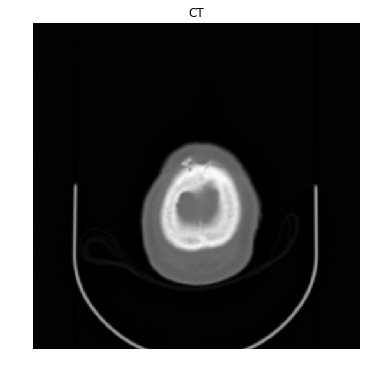

In [9]:
plt.figure(figsize=(6, 6))
plt.imshow(gray, 'gray')
plt.axis('off')
plt.title('CT')
display()

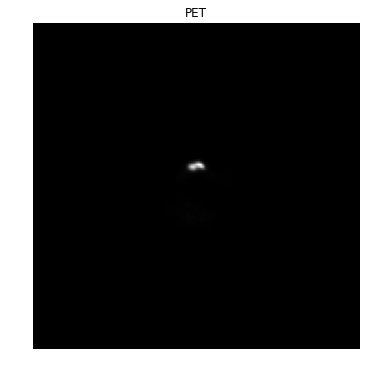

In [10]:
plt.figure(figsize=(6, 6))
plt.imshow(ir, 'gray')
plt.axis('off')
plt.title('PET')
display()

In [11]:
f = fuse(gray, ir)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
 0%| | 0.00/548M [00:00<?, ?B/s] 0%| | 1.25M/548M [00:00<00:44, 13.0MB/s] 1%| | 4.06M/548M [00:00<00:36, 15.4MB/s] 2%|▏ | 8.62M/548M [00:00<00:29, 19.3MB/s] 2%|▏ | 11.9M/548M [00:00<00:25, 22.2MB/s] 3%|▎ | 18.1M/548M [00:00<00:20, 27.6MB/s] 4%|▍ | 23.1M/548M [00:00<00:17, 32.1MB/s] 5%|▍ | 27.1M/548M [00:00<00:16, 34.1MB/s] 6%|▌ | 32.4M/548M [00:00<00:14, 38.3MB/s] 7%|▋ | 40.7M/548M [00:00<00:11, 45.6MB/s] 8%|▊ | 46.1M/548M [00:01<00:10, 48.4MB/s] 10%|▉ | 53.2M/548M [00:01<00:09, 53.7MB/s] 11%|█ | 60.6M/548M [00:01<00:08, 59.2MB/s] 12%|█▏ | 66.9M/548M [00:01<00:08, 60.7MB/s] 13%|█▎ | 73.6M/548M [00:01<00:08, 61.7MB/s] 15%|█▍ | 81.1M/548M [00:01<00:07, 66.0MB/s] 16%|█▌ | 88.4M/548M [00:01<00:07, 68.7MB/s] 17%|█▋ | 95.1M/548M [00:01<00:06, 68.4MB/s] 19%|█▉ | 103M/548M [00:01<00:06, 72.0MB/s]  20%|██ | 110M/548M [00:01<00:06, 66.6MB/s] 21%|██▏ | 118M/548M [00:02<00:06, 69.3MB/s] 23%|██▎ | 124M/548M [00:02<00:06, 68.5MB/s] 24%|██▍ | 131M/548M [00:02<00:06, 64.9MB/s] 25%|██▌ | 138M/548M [00:02<00:06, 63.8MB/s] 26%|██▌ | 144M/548M [00:02<00:07, 59.4MB/s] 27%|██▋ | 150M/548M [00:02<00:06, 61.9MB/s] 29%|██▉ | 160M/548M [00:02<00:05, 69.1MB/s] 30%|███ | 166M/548M [00:02<00:05, 67.6MB/s] 32%|███▏ | 173M/548M [00:02<00:05, 69.2MB/s] 33%|███▎ | 182M/548M [00:03<00:05, 74.0MB/s] 35%|███▍ | 191M/548M [00:03<00:04, 78.4MB/s] 36%|███▌ | 198M/548M [00:03<00:04, 77.6MB/s] 38%|███▊ | 207M/548M [00:03<00:04, 82.0MB/s] 39%|███▉ | 215M/548M [00:03<00:04, 81.4MB/s] 41%|████ | 223M/548M [00:03<00:04, 80.2MB/s] 42%|████▏ | 232M/548M [00:03<00:04, 82.8MB/s] 44%|████▍ | 240M/548M [00:03<00:03, 83.2MB/s] 45%|████▌ | 249M/548M [00:03<00:03, 85.2MB/s] 47%|████▋ | 258M/548M [00:03<00:03, 87.8MB/s] 49%|████▊ | 266M/548M [00:04<00:03, 84.6MB/s] 50%|█████ | 275M/548M [00:04<00:03, 86.7MB/s] 52%|█████▏ | 283M/548M [00:04<00:03, 81.1MB/s] 53%|█████▎ | 291M/548M [00:04<00:03, 81.3MB/s] 55%|█████▍ | 299M/548M [00:04<00:03, 79.7MB/s] 56%|█████▌ | 306M/548M [00:04<00:03, 79.7MB/s] 57%|█████▋ | 314M/548M [00:04<00:03, 78.1MB/s] 59%|█████▉ | 323M/548M [00:04<00:02, 81.1MB/s] 60%|██████ | 331M/548M [00:05<00:03, 65.7MB/s] 62%|██████▏ | 337M/548M [00:05<00:03, 67.2MB/s] 63%|██████▎ | 344M/548M [00:05<00:03, 68.7MB/s] 64%|██████▍ | 351M/548M [00:05<00:02, 70.0MB/s] 65%|██████▌ | 358M/548M [00:05<00:02, 67.2MB/s] 67%|██████▋ | 368M/548M [00:05<00:02, 74.0MB/s] 68%|██████▊ | 375M/548M [00:05<00:02, 67.4MB/s] 70%|███████ | 384M/548M [00:05<00:02, 73.5MB/s] 71%|███████▏ | 391M/548M [00:05<00:02, 71.3MB/s] 73%|███████▎ | 400M/548M [00:05<00:02, 76.0MB/s] 75%|███████▍ | 408M/548M [00:06<00:01, 79.8MB/s] 76%|███████▌ | 416M/548M [00:06<00:02, 67.2MB/s] 77%|███████▋ | 424M/548M [00:06<00:01, 70.5MB/s] 79%|███████▉ | 432M/548M [00:06<00:01, 72.8MB/s] 80%|████████ | 439M/548M [00:06<00:01, 73.1MB/s] 82%|████████▏ | 447M/548M [00:06<00:01, 75.1MB/s] 83%|████████▎ | 455M/548M [00:06<00:01, 78.8MB/s] 84%|████████▍ | 463M/548M [00:06<00:01, 71.3MB/s] 86%|████████▌ | 470M/548M [00:07<00:01, 67.8MB/s] 87%|████████▋ | 477M/548M [00:07<00:01, 59.8MB/s] 88%|████████▊ | 483M/548M [00:07<00:01, 53.3MB/s] 89%|████████▉ | 490M/548M [00:07<00:01, 59.3MB/s] 91%|█████████ | 498M/548M [00:07<00:00, 62.3MB/s] 92%|█████████▏| 504M/548M [00:07<00:00, 58.7MB/s] 93%|█████████▎| 511M/548M [00:07<00:00, 61.3MB/s] 95%|█████████▍| 519M/548M [00:07<00:00, 67.9MB/s] 96%|█████████▌| 526M/548M [00:07<00:00, 66.2MB/s] 97%|█████████▋| 533M/548M [00:08<00:00, 53.3MB/s] 98%|█████████▊| 540M/548M [00:08<00:00, 57.9MB/s]100%|██████████| 548M/548M [00:08<00:00, 68.6MB/s]

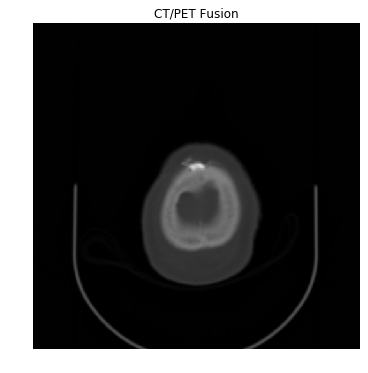

In [12]:
path_fusion_png = '/dbfs/tmp/cpee2020/fusion_' + pet_rescaled_name[8:]

plt.figure(figsize=(6, 6))
plt.imshow(f, 'gray')
plt.axis('off')
plt.title('CT based fusion with PET')
plt.savefig(path_fusion_png)

display()